## Read time series data and split

In [1]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import discretize_func as discretize
import tokenizer_func as tokenizer
import pickle

In [2]:
# Read
df = pd.read_parquet("dehli.parquet")

# Fill nans with nearest
df = df.ffill()

# Downsample from 5-min resolution to hourly
df = df.resample("h").mean()

# Downsample from 5-min resolution to quarterly
#df = df.resample("15min").mean()

# Change to numeric index (remove datetime)
df = df.reset_index(drop=True)

# Fill nans with nearest
df = df.ffill()

# Columns of interest
cols = ['Power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']
df = df[cols]

# Split in train/test
split_idx = int(len(df) * 0.8)
X = df.iloc[:split_idx].copy()
Y = df.iloc[split_idx:].copy()

## Pre-processing

* Normalize
* Delta tokens by derivation
* Discretize each column

Current setup:
* delta tokens
* n_bins = 256
* quantile-based bins (centered at 0)

In [3]:
# Z-norm standardisation
#X['Power demand'] = np.log1p(X['Power demand'])
mu = X.mean(axis=0)
sigma = X.std(axis=0) + 1e-8

X_normalized = (X-mu)/sigma
X_normalized = X_normalized.diff().dropna()
X_nv = X_normalized.values.astype(np.float32)   # (N, D)

In [4]:
# fit bins
n_bins=256

#edges, mids = discretize.fit_quantile_bins_global(X_nv, n_bins=n_bins)
edges, mids = discretize.fit_equal_width_bins_global(X_nv, n_bins=n_bins)

# encode
#X_tok = discretize.encode_quantile_global(jnp.asarray(X_nv), edges)
X_tok = discretize.encode_equal_width_global(jnp.asarray(X_nv), edges)

# decode
#X_rec = discretize.decode_quantile_global(X_tok, mids)
X_rec = discretize.decode_equal_width_global(X_tok, mids)

ZERO_BIN = int(np.argmin(np.abs(mids)))
#or
assert(ZERO_BIN == discretize.encode_equal_width_global(jnp.asarray([0]), edges))

print("Zero midpoint:", mids[ZERO_BIN])
print("Index:", ZERO_BIN)


Zero midpoint: -0.0064048767
Index: 128


In [5]:
X_normalized

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
1,-0.137114,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,-0.112688,-0.061602,-0.089990,-0.041230,0.000000,0.00000,0.152233
3,-0.047263,-0.061602,0.006922,0.144305,0.000000,0.00000,0.000000
4,0.055827,-0.061602,0.027689,0.185536,0.000000,0.00000,-0.152233
5,0.251982,-0.147844,-0.256124,-0.185536,0.000000,0.00000,0.173980
...,...,...,...,...,...,...,...
27663,-0.089561,-0.061602,-0.207668,-0.082460,0.045609,-0.16581,-0.072492
27664,-0.018132,-0.012320,-0.283813,-0.164921,0.000000,-0.16581,-0.065243
27665,0.114572,-0.061602,0.083067,0.082460,-0.045609,0.00000,-0.014498
27666,0.146685,-0.123203,0.089990,0.123690,-0.136826,-0.33162,0.000000


In [6]:
pd.DataFrame(X_tok)

,0,1,2,3,4,5,6
0,125,128,128,128,128,128,128
1,125,127,126,127,128,128,132
2,127,127,128,132,128,128,128
3,130,127,129,133,128,128,124
4,135,124,122,123,128,128,133
...,...,...,...,...,...,...,...
27662,126,127,123,126,129,124,126
27663,128,128,121,124,128,124,126
27664,131,127,130,130,127,128,128
27665,132,125,130,131,125,120,128


In [7]:
pd.DataFrame(X_rec)

,0,1,2,3,4,5,6
0,-0.122731,-0.006405,-0.006405,-0.006405,-0.006405,-0.006405,-0.006405
1,-0.122731,-0.045180,-0.083956,-0.045180,-0.006405,-0.006405,0.148696
2,-0.045180,-0.045180,-0.006405,0.148696,-0.006405,-0.006405,-0.006405
3,0.071146,-0.045180,0.032371,0.187472,-0.006405,-0.006405,-0.161506
4,0.265023,-0.161506,-0.239057,-0.200282,-0.006405,-0.006405,0.187472
...,...,...,...,...,...,...,...
27662,-0.083956,-0.045180,-0.200282,-0.083956,0.032371,-0.161506,-0.083956
27663,-0.006405,-0.006405,-0.277833,-0.161506,-0.006405,-0.161506,-0.083956
27664,0.109921,-0.045180,0.071146,0.071146,-0.045180,-0.006405,-0.006405
27665,0.148696,-0.122731,0.071146,0.109921,-0.122731,-0.316608,-0.006405


## Tokenize
* Tokenize each row: Channel+Value (on change), special time step token: 0

Token layout

* 0	BOS (beginning of sequence / row)
* CH_0 … CH_6  →  IDs 2 … 8 (channel tokens)
* DATA ≥ DATA_OFFSET = 2 + N_CHANNELS = 9 (data tokens)
* 1	EOS (end of row)

Example:

```
[BOS,
 CH_0, DATA(x0),
 CH_1, DATA(x1),
 ...
 CH_6, DATA(x6),
 EOS]
```

In [8]:
n_channels = len(X.columns)
#tokens = tokenizer.encode_with_channels(X_tok, n_channels)
tokens = tokenizer.encode_with_channels_sparse(X_tok, n_channels, ZERO_BIN)

DATA_OFFSET = 2 + n_channels  # BOS+EOS+n_channels = 9
vocab_size = DATA_OFFSET + n_bins

In [9]:
ROW_LEN = 2 + 2 * n_channels

T = tokens.shape[0]
print("Total tokens:", T)
print("Vocab size:", vocab_size)
print("ROW_LEN:", ROW_LEN)
print("Remainder:", T % ROW_LEN)

# Inspect first few tokens
print("First 100 tokens:", tokens[:100])
print("First 3 rows reshaped (raw):")
print(tokens[:3 * ROW_LEN].reshape(3, ROW_LEN))

Total tokens: 354746
Vocab size: 265
ROW_LEN: 16
Remainder: 10
First 100 tokens: [  0   2 134   1   0   2 134   3 136   4 135   5 136   8 141   1   0   2
 136   3 136   5 141   1   0   2 139   3 136   4 138   5 142   8 133   1
   0   2 144   3 133   4 131   5 132   8 142   1   0   2 151   3 136   4
 134   5 133   8 139   1   0   2 155   3 138   4 138   5 138   8 136   1
   0   2 151   4 138   5 138   8 144   1   0   2 146   3 140   4 139   5
 134   8 139   1   0   2 143   3 146   4]
First 3 rows reshaped (raw):
[[  0   2 134   1   0   2 134   3 136   4 135   5 136   8 141   1]
 [  0   2 136   3 136   5 141   1   0   2 139   3 136   4 138   5]
 [142   8 133   1   0   2 144   3 133   4 131   5 132   8 142   1]]


# Training

In [10]:
import os
import requests
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import optax
from jax import value_and_grad
import pickle
import pandas as pd
import math

from helper_funcs import generate, masked_fill
from tqdm import tqdm
import matplotlib.pyplot as plt
print(jax.devices())

[CpuDevice(id=0)]


In [11]:
n_embed = 32 # Number of embedding dimensions
batch_size = 4 # How many independent sequences will we process in parallel?
block_size = 480 # What is the maximum context length for predictions?
num_heads = 4 # Number of heads in the multi-headed block
num_layers = 6 # Number of transformer decoder blocks
drop_rate = 0.1 # Dropout rate for regularization

rng_key = jax.random.PRNGKey(42)

In [12]:
rng_key, subkey = jax.random.split(rng_key)
xb, yb = tokenizer.get_token_batch(tokens, subkey, batch_size, n_channels, block_size)
token_types = tokenizer.compute_token_types(xb, n_channels)

## Build the Attention Model

In [13]:
from attention_model import *
model = GPT2_v3(vocab_size, n_embed, block_size, num_heads, num_layers, drop_rate, n_channels)
dummy_x = jnp.zeros(shape=(batch_size, block_size), dtype=jnp.uint16)
dummy_token_types = jnp.zeros_like(dummy_x)
dummy_channel_ids = jnp.zeros_like(dummy_x)
variables = model.init(rng_key, dummy_x, dummy_token_types, dummy_channel_ids)

In [14]:
out = model.apply(variables, dummy_x, dummy_token_types, dummy_channel_ids)
print(out.shape)

(4, 480, 265)


## Time Series Generation Pre-Training

In [15]:
#index_seq = jnp.zeros(shape=(1,1), dtype=jnp.uint16)
#max_new_tokens = 240
learning_rate=1e-5

#generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
#generated_indices = list(np.array(generated_indices[0]))
#decode(generated_indices, X)

## Train the Model

In [16]:
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate)
)
opt_state = optimizer.init(variables)
losses = []

**Cross-entropy intuition**

For a model that is basically guessing, the expected loss is:

$$loss≈log⁡(vocab size)$$

More epochs will just produce more samples of the same noise band.

In [17]:
np.log(vocab_size)

np.float64(5.579729825986222)

In [18]:
epochs = 500
train_tokens = tokens

pbar = tqdm(range(epochs))
for epoch in pbar:
    rng_key, subkey = jax.random.split(rng_key)
    xb, yb = tokenizer.get_token_batch(train_tokens, subkey, batch_size, n_channels, block_size)
    token_types = tokenizer.compute_token_types(xb, n_channels)
    channel_ids = tokenizer.compute_channel_ids(xb, n_channels)

    loss, grads = value_and_grad(tokenizer.loss_fn, argnums=(0))(
        variables, 
        model.apply,
        xb, 
        token_types,
        channel_ids,
        n_channels,
        yb
    )

    if math.isnan(loss):
        print(f"Premature stop (loss=nan) at epoch {epoch}")
        break

    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)
    losses.append(loss)
    
    pbar.set_description(f"Epoch: {epoch}, Loss: {loss :.4f}")

Epoch: 499, Loss: 4.2666: 100%|██████████| 500/500 [04:54<00:00,  1.70it/s]


In [19]:
# Save model
model_file = {
    "epochs": epochs,
    "epoch": epoch,
    "model": model,
    "vocab_size": vocab_size,
    "block_size": block_size,
    "variables": variables,
    "losses": losses,
    "opt_state": opt_state,
    "learning_rate": learning_rate,
    "n_channels": n_channels,
    "n_bins": n_bins,
    "edges": edges, 
    "mids": mids,
    "mu": mu,
    "sigma": sigma,
}

with open('token_model.pkl', 'wb') as f:
    pickle.dump(model_file, f)

In [20]:
# Load model
#with open('token_model.pkl', 'rb') as f:
#    model_file = pickle.load(f)

#globals().update(model_file)

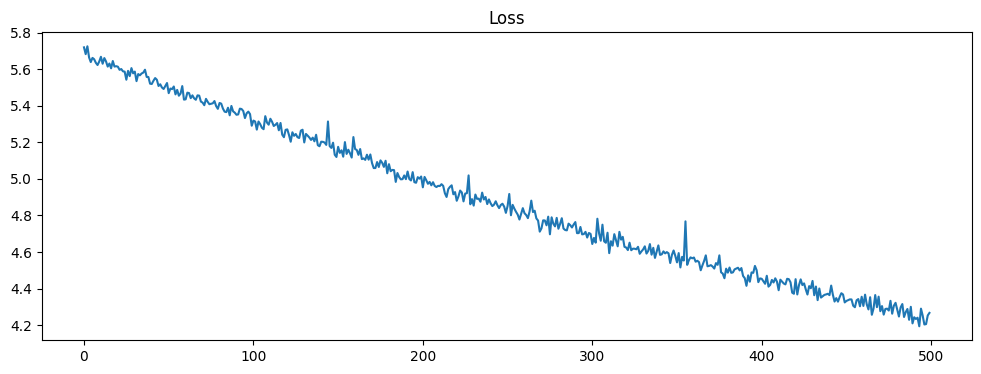

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

## Time Series Generation Post-Training

In [22]:
rng_key = jax.random.PRNGKey(128)

In [38]:
from functools import partial
import jax
import jax.numpy as jnp
from jax import lax

def infer_token_types_and_channels(tokens, n_channels):
    """
    tokens: (B, T)
    returns:
        token_types: (B, T)
        channel_ids: (B, T)
    """
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    # token type ids
    token_types = jnp.where(
        tokens == BOS, 0,
        jnp.where(
            tokens == EOS, 1,
            jnp.where(
                tokens < DATA_OFFSET, 2,  # CH
                3                           # DATA
            )
        )
    )

    # channel ids
    channel_ids = jnp.where(
        (tokens >= CH_OFFSET) & (tokens < DATA_OFFSET),
        tokens - CH_OFFSET,
        0
    )

    return token_types, channel_ids

def token_type(tok, n_channels):
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    return jnp.where(
        tok == BOS, 0,
        jnp.where(
            tok == EOS, 1,
            jnp.where(
                tok < DATA_OFFSET, 2,  # CH
                3                       # DATA
            )
        )
    )

def grammar_mask(last_tok, n_channels, vocab_size):
    """
    Returns mask: True = allowed, False = forbidden
    """
    BOS = 0
    EOS = 1
    CH_OFFSET = 2
    DATA_OFFSET = 2 + n_channels

    ttype = token_type(last_tok, n_channels)

    allowed = jnp.zeros((vocab_size,), dtype=jnp.bool_)

    def allow(mask, lo, hi):
        return mask.at[lo:hi].set(True)

    # BOS → CH or EOS
    allowed = jax.lax.cond(
        ttype == 0,
        lambda m: allow(allow(m, CH_OFFSET, DATA_OFFSET), EOS, EOS + 1),
        lambda m: m,
        allowed
    )

    # CH → DATA
    allowed = jax.lax.cond(
        ttype == 2,
        lambda m: allow(m, DATA_OFFSET, vocab_size),
        lambda m: m,
        allowed
    )

    # DATA → CH or EOS
    allowed = jax.lax.cond(
        ttype == 3,
        lambda m: allow(allow(m, CH_OFFSET, DATA_OFFSET), EOS, EOS + 1),
        lambda m: m,
        allowed
    )

    # EOS → EOS only
    allowed = jax.lax.cond(
        ttype == 1,
        lambda m: m.at[EOS].set(True),
        lambda m: m,
        allowed
    )

    return allowed

@partial(
    jax.jit,
    static_argnames=[
        'forward_fn',
        'vocab_size',
        'block_size',
        'max_new_tokens',
        'n_channels',
    ],
)
def generate_sparse(
    variables,
    forward_fn,
    index_seq,     # (T,)
    rng_key,
    vocab_size,
    block_size,
    max_new_tokens,
    n_channels,
    EOS=1,
):
    # ---------- setup ----------
    index_seq = jnp.asarray(index_seq)
    T = index_seq.shape[0]
    B = 1

    total_len = block_size + T + max_new_tokens

    # output buffer
    out = jnp.zeros((B, total_len), dtype=index_seq.dtype)

    # write initial tokens after padding
    out = lax.dynamic_update_slice(
        out,
        index_seq[None, :],
        (0, block_size),
    )

    # initial write position
    write_pos = block_size + T

    finished = jnp.zeros((B,), dtype=jnp.bool_)

    def step(carry, _):
        out, rng, write_pos, finished = carry

        # context window
        ctx = lax.dynamic_slice(
            out,
            (0, write_pos - block_size),
            (B, block_size),
        )

        token_types, channel_ids = infer_token_types_and_channels(
            ctx, n_channels
        )

        logits = forward_fn(
            variables,
            ctx,
            token_types,
            channel_ids,
        )
        logits = logits[:, -1]

        last_tok = ctx[:, -1]   # shape (B,)

        rng, sub = jax.random.split(rng)
        mask = grammar_mask(last_tok[0], n_channels, vocab_size)

        temperature = 1.   # try 1.2 → 1.5
        masked_logits = jnp.where(mask, logits / temperature, -1e9)

        #noise = 0.05 * jax.random.normal(sub, logits.shape)
        #masked_logits = masked_logits + noise

        next_tok = jax.random.categorical(sub, masked_logits)

        # force EOS if finished
        next_tok = jnp.where(finished, EOS, next_tok)

        # write token
        out = lax.dynamic_update_slice(
            out,
            next_tok[:, None],
            (0, write_pos),
        )

        finished = jnp.logical_or(finished, next_tok == EOS)
        write_pos = write_pos + 1

        return (out, rng, write_pos, finished), None

    (out, _, write_pos, _), _ = lax.scan(
        step,
        (out, rng_key, write_pos, finished),
        None,
        length=max_new_tokens,
    )

    # return only valid portion (remove padding)
    return out[0], write_pos

In [39]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens].reset_index(drop=True)

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
#X_test_normalized = X_test_normalized.diff().dropna()
X_test_nv = X_test_normalized.values.astype(np.float32)   # (N, D)

# Discretize
#X_test_tok = discretize.encode_equal_width_global(jnp.asarray(X_test_nv), edges)
#test_tokens = tokenizer.encode_with_channels_sparse(X_test_tok, n_channels, ZERO_BIN)

#buf, write_pos = generate_sparse(
#    variables,
#    model.apply,
#    test_tokens,   # must end in EOS
#    rng_key,
#    vocab_size=vocab_size,
#    block_size=block_size,
#    max_new_tokens=128,
#    n_channels=n_channels
#)
#generated = buf[block_size:write_pos]

# Check structural validity of generated tokens
gen = generated

assert gen[0] == 0           # BOS
assert 1 in gen              # EOS exists

# no PAD, no negative tokens
assert (gen >= 0).all()

# channel tokens are in range
CH_OFFSET = 2
DATA_OFFSET = 2 + n_channels

ch_mask = (gen >= CH_OFFSET) & (gen < DATA_OFFSET)
assert ch_mask.sum() > 0     # at least one channel event

# Check CH → DATA pairing
i = 0
while i < len(gen):
    if gen[i] == 0:          # BOS
        i += 1
        continue
    if gen[i] == 1:          # EOS
        break

    # must be CH_k
    assert CH_OFFSET <= gen[i] < DATA_OFFSET
    # must be DATA
    assert gen[i+1] >= DATA_OFFSET

    i += 2


In [99]:
def decode_sparse_row(tokens, n_channels, zero_bin, mids):
    """
    tokens: (L,) sparse token row (BOS ... EOS)
    returns: (D,) delta vector
    """
    D = n_channels
    delta = jnp.full((D,), mids[zero_bin])

    i = 0
    while i < len(tokens):
        tok = tokens[i]

        if tok == 0 or tok == 1:  # BOS / EOS
            i += 1
            continue

        ch = tok - 2
        data = tokens[i + 1] - (2 + n_channels)

        delta = delta.at[ch].set(mids[data])
        i += 2

    return delta

def encode_dense_row_to_sparse(
    x_row,           # (D,)
    prev_x_row,      # (D,)
    edges,
    zero_bin,
    n_channels,
):
    """
    Dense → delta → discretize → sparse tokens
    """
    # delta
    delta = x_row - prev_x_row

    # discretize (global)
    delta_bins = discretize.encode_equal_width_global(
        delta[None, :], edges
    )[0]

    # sparse tokenize
    tokens = tokenizer.encode_with_channels_sparse(
        delta_bins[None, :],
        n_channels,
        zero_bin,
    )

    return tokens

def trim_at_eos(tokens, EOS=1):
    idx = jnp.argmax(tokens == EOS)
    return tokens[:idx + 1]

def extract_last_row(token_stream, write_pos, BOS=0, EOS=1):
    stream = token_stream[:write_pos]

    eos_idx = jnp.max(
        jnp.where(stream == EOS, size=stream.shape[0], fill_value=-1)[0]
    )

    bos_idx = jnp.max(
        jnp.where(stream[:eos_idx] == BOS, size=stream.shape[0], fill_value=-1)[0]
    )

    return stream[bos_idx : eos_idx + 1]
    
def rollout_one_step(
    variables,
    model,
    rng_key,
    token_stream,    # NEW
    write_pos,       # NEW
    last_x,          # (D,)
    prev_x,          # (D,)
    edges,
    mids,
    zero_bin,
    n_channels,
    block_size,
    max_new_tokens,
):
    # encode conditioning row
    #cond_tokens = encode_dense_row_to_sparse(
    #    last_x,
    #    prev_x,
    #    edges,
    #    zero_bin,
    #    n_channels,
    #)
    #print(token_stream[:write_pos])

    # generate next sparse row
    buf, write_pos = generate_sparse(
        variables,
        model.apply,
        token_stream[:write_pos], #cond_tokens,
        rng_key,
        vocab_size=vocab_size,
        block_size=block_size,
        max_new_tokens=max_new_tokens,
        n_channels=n_channels,
    )
    
    token_stream = buf

    #gen_tokens = buf[block_size:write_pos]
    gen_tokens = extract_last_row(token_stream, write_pos)
    gen_tokens = trim_at_eos(gen_tokens)
    #print(gen_tokens)
    
    # decode to delta
    delta_hat = decode_sparse_row(
        gen_tokens,
        n_channels,
        zero_bin,
        mids,
    )

    # apply delta
    next_x = last_x + delta_hat

    #return next_x, gen_tokens
    return next_x, token_stream, write_pos

def autoregressive_rollout(
    variables,
    model,
    rng_key,
    X_init,          # (T0, D)
    steps,
    edges,
    mids,
    zero_bin,
    n_channels,
    block_size,
    max_new_tokens,
):
    X = [X_init[-1]]
    prev = X_init[-2]

    tokens_out = []

    token_stream = encode_dense_row_to_sparse(
        X_init[-1],
        X_init[-2],
        edges,
        zero_bin,
        n_channels,
    )
    write_pos = token_stream.shape[0]

    for _ in range(steps):
        rng_key, sub = jax.random.split(rng_key)

        #next_x, gen_tokens = rollout_one_step(
        next_x, token_stream, write_pos = rollout_one_step(
            variables,
            model,
            sub,
            token_stream,
            write_pos,
            X[-1],
            prev,
            edges,
            mids,
            zero_bin,
            n_channels,
            block_size,
            max_new_tokens,
        )

        prev = X[-1]
        X.append(next_x)
        gen_tokens = trim_at_eos(extract_last_row(token_stream, write_pos))
        tokens_out.append(gen_tokens)
        
        token_stream = jnp.concatenate(tokens_out)
        write_pos = token_stream.shape[0]

    print(token_stream)
    print(tokens_out)
    return jnp.stack(X), tokens_out



In [100]:
X_test_nv[-2:]#3:-1]

array([[-1.3071455 , -0.2999784 , -0.3036248 , -0.25178745,  0.0654311 ,
         0.31396535,  0.19454958],
       [-1.3811773 , -0.3985411 , -0.33823618, -0.16932718, -1.3484378 ,
        -0.22031124,  0.14380537]], dtype=float32)

In [101]:
# last observed dense rows (normalized space)
X_init = jnp.asarray(X_test_nv[-2:])   # shape (2, D)

print("Initial rows:")
print(X_init)

X_gen, gen_tokens = autoregressive_rollout(
    variables=variables,
    model=model,
    rng_key=rng_key,
    X_init=X_init,            # (2, D)
    steps=20,                 # rollout horizon
    edges=edges,
    mids=mids,
    zero_bin=ZERO_BIN,
    n_channels=n_channels,
    block_size=block_size,
    max_new_tokens=64,        # per-row cap
)

Initial rows:
[[-1.3071455  -0.2999784  -0.3036248  -0.25178745  0.0654311   0.31396535
   0.19454958]
 [-1.3811773  -0.3985411  -0.33823618 -0.16932718 -1.3484378  -0.22031124
   0.14380537]]
[  0   2 135   3 135   4 136   5 139   6 101   7 123   8 136   1   0   2
 135   3 135   4 136   5 139   6 101   7 123   8 136   1   0   2 135   3
 135   4 136   5 139   6 101   7 123   8 136   1   0   2 135   3 135   4
 136   5 139   6 101   7 123   8 136   1   0   2 135   3 135   4 136   5
 139   6 101   7 123   8 136   1   0   2 135   3 135   4 136   5 139   6
 101   7 123   8 136   1   0   2 135   3 135   4 136   5 139   6 101   7
 123   8 136   1   0   2 135   3 135   4 136   5 139   6 101   7 123   8
 136   1   0   2 135   3 135   4 136   5 139   6 101   7 123   8 136   1
   0   2 135   3 135   4 136   5 139   6 101   7 123   8 136   1   0   2
 135   3 135   4 136   5 139   6 101   7 123   8 136   1   0   2 135   3
 135   4 136   5 139   6 101   7 123   8 136   1   0   2 135   3 135   4
 136

In [97]:
for i, t in enumerate(gen_tokens[:5]):
    t_clean = trim_at_eos(t)
    print(f"Step {i} tokens:", t_clean)

Step 0 tokens: [  0   2 135   3 135   4 136   5 139   6 101   7 123   8 136   1]
Step 1 tokens: [  0   2 135   3 135   4 136   5 139   6 101   7 123   8 136   1]
Step 2 tokens: [  0   2 135   3 135   4 136   5 139   6 101   7 123   8 136   1]
Step 3 tokens: [  0   2 135   3 135   4 136   5 139   6 101   7 123   8 136   1]
Step 4 tokens: [  0   2 135   3 135   4 136   5 139   6 101   7 123   8 136   1]


In [98]:
X_gen_space = pd.DataFrame(X_gen, columns=X.columns) * sigma + mu
X_gen_space

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
0,2114.366602,21.500000,13.500000,60.500000,10.000006,6.500000,1010.500000
1,2010.304193,20.818559,13.173660,62.225577,-143.733632,3.518672,1010.188376
2,1906.241784,20.137119,12.847319,63.951154,-297.467271,0.537345,1009.876752
3,1802.179375,19.455678,12.520979,65.676732,-451.200909,-2.443983,1009.565128
4,1698.116966,18.774238,12.194639,67.402309,-604.934548,-5.425311,1009.253504
5,1594.054558,18.092797,11.868298,69.127886,-758.668186,-8.406639,1008.941880
6,1489.992149,17.411357,11.541958,70.853463,-912.401877,-11.387967,1008.630256
7,1385.929740,16.729916,11.215618,72.579040,-1066.135568,-14.369294,1008.318632
8,1281.867183,16.048476,10.889277,74.304617,-1219.869259,-17.350623,1008.007008
9,1177.804775,15.367035,10.562937,76.030195,-1373.602949,-20.331952,1007.695384


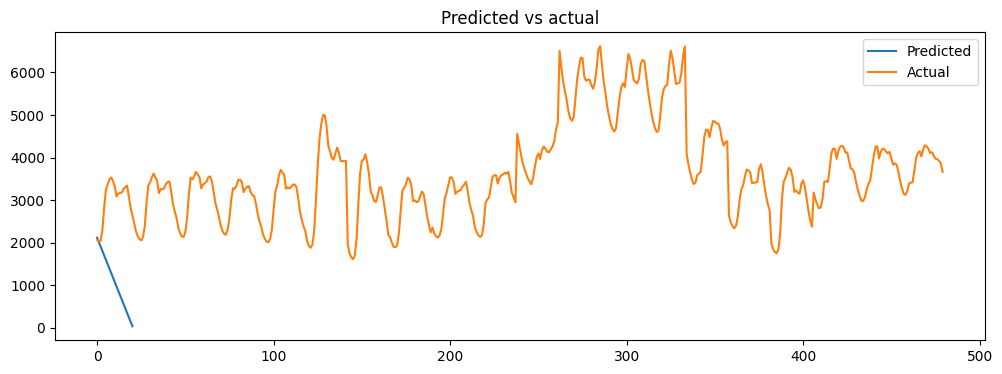

In [76]:
plt.figure(figsize=(12, 4))
plt.plot(X_gen_space.index, X_gen_space['Power demand'], label="Predicted")
plt.plot(Y_test.index, Y_test['Power demand'], label="Actual")
plt.title('Predicted vs actual')
plt.legend()
plt.show()

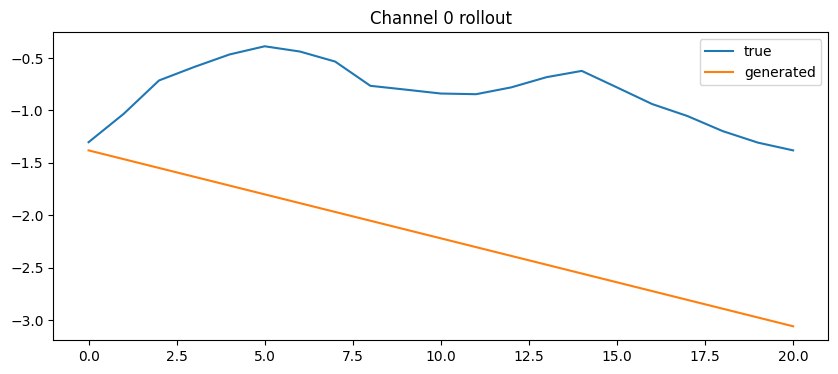

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(X_test_nv[-21:, 0], label="true")
plt.plot(X_gen[:, 0], label="generated")
plt.title("Channel 0 rollout")
plt.legend()
plt.show()